<a href="https://colab.research.google.com/github/rdc143/GazelleProject/blob/main/InferFreq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas-plink

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 4.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 43.4 MB/s eta 0:00:00
  Created wheel for pandas-plink: filename=pandas_plink-2.2.9-cp310-cp310-linux_x86_64.whl size=99376 sha256=c7414a0f25ba55f4fe6c4896bc1bc7f37b3667d4110e9233960cd95717cd0f65
  Stored in directory: /root/.cache/pip/wheels/7c/c7/31/e8a222d6530933b3195c6baeb7fa79e178b4c8b6ea928a18f8
Successfully built pandas-plink


In [ ]:
import numpy as np
import pandas as pd
from pandas_plink import read_plink
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
import copy
from scipy.optimize import fixed_point
from scipy.stats import chi2
from scipy.stats import uniform

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

%cd /content/drive/My Drive/Colab Notebooks/

Mounted at /content/drive/
/content/drive/My Drive/Colab Notebooks


In [ ]:
### Load data
(bim, fam, bed) = read_plink("./Gazelle/*ch5.bed")

fam["gender"] = fam["gender"].astype(int)
sex = np.array(fam["gender"]) / 2 # admixture proportions, proportion of autosomal linked(in contrast to y-linked)
male = sex < 1

missing = np.mean(np.isnan(bed), axis = 1)
#sns.kdeplot(missing)
#plt.show()

freq = np.nanmean(bed, axis = 1) / 2
#sns.kdeplot(freq)
#plt.show()

keep = (0.1 < freq) & (freq < 0.9) & (missing == 0) ## is first statement neccessary?
#sns.kdeplot(keep)
#plt.show()

#np.random.seed(seed=42)

geno = bed.compute()[keep] # allele counts for first allele, variant per row, individual per column
#geno = 2 - geno  # flip all alleles
for i in range(len(geno)): # flip alleles at random
  if np.random.uniform() > 0.5:
    geno[i] = 2 - geno[i]

Mapping files: 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]


In [ ]:
### Funcs
def EMInferFreqs(x, geno, male, fixY=False, fixA=False):
  f = copy.copy(x) # f[0] is f_Y and f[1] is f_A
  G = np.array([np.where(geno > 1, 1, 0),
                np.where(geno > 0, 1, 0)])[:,male] # ordered genotypes for males, TODO: replace with boolean, (do only for male?), do outside func?

  p_YA = np.where(G[0] == 1, f[0], (1 - f[0])) * np.where(G[1] == 1, f[1], (1 - f[1]))

  p_AY = np.where(G[0] == 1, f[1], (1 - f[1])) * np.where(G[1] == 1, f[0], (1 - f[0]))

  q_YA = p_YA / (p_AY + p_YA)
  q_AY = p_AY / (p_AY + p_YA)

  E_c_Y = np.sum(q_AY * G[1]) + np.sum(q_YA * G[0])
  E_C_Y = np.sum(q_AY * (1 - G[1])) + np.sum(q_YA * (1 - G[0]))

  E_c_A = np.sum(geno[~male]) + np.sum(q_AY * G[0]) + np.sum(q_YA * G[1])
  E_C_A = np.sum(2 - geno[~male]) + np.sum(q_AY * (1 - G[0])) + np.sum(q_YA * (1 - G[1]))

  if fixY: return np.array([fixY,
                   E_c_A / (E_c_A + E_C_A)])
  if fixA: return np.array([E_c_Y / (E_c_Y + E_C_Y),
                   fixA])

  return np.array([E_c_Y / (E_c_Y + E_C_Y),
                   E_c_A / (E_c_A + E_C_A)])


def ll(f, G, male):
  #to avoid problems with log computation and boundary of param space
  if f[0] <= 1e-4: f[0] = 1e-4
  if f[1] <= 1e-4: f[1] = 1e-4
  if f[0] >= 1 - 1e-4: f[0] = 1 - 1e-4
  if f[1] >= 1 - 1e-4: f[1] = 1 - 1e-4

  isG = np.array([G == 0, G == 1, G == 2])
  M = (np.sum(isG[0] & male), # counts of male
       np.sum(isG[1] & male),
       np.sum(isG[2] & male))
  F = (np.sum(isG[0] & ~male), # counts of female
       np.sum(isG[1] & ~male),
       np.sum(isG[2] & ~male))

  return (np.log((1 - f[0])*(1 - f[1])) * M[0] +
          np.log((f[1]*(1 - f[0]) + f[0]*(1 - f[1]))) * M[1] +
          np.log((f[0]*f[1])) * M[2] +
          np.log(((1 - f[1])**2)) * F[0] +
          np.log((2*(1 - f[1])*f[1])) * F[1] +
          np.log((f[1]**2)) * F[2])


def converge(geno, male, fixY=False, fixA=False, randomInit=False):
  if np.any(np.isnan(geno)): raise Exception("Nan in genotypes >:(") # check to make sure no nans are passed, even though at this point they should be filtered out
  if randomInit:  # initialization
    f = np.array([np.random.uniform(.1, .9), np.random.uniform(.1, .9)])
  else:
    f = np.array([0.5, 0.5])

  change = np.array([float("Inf"), float("Inf")])
  it = 0
  while any(change > 1e-4) and it <= 500: # tolerance
    fnew = EMInferFreqs(f, geno, male, fixY=fixY, fixA=fixA)
    change = np.abs(f - fnew)
    f = fnew
    it +=1
    if it > 500: print(f"Max iterations reached {i}")
    #print((it, f))
    #print((it, ll(f, geno, male)))
  return f


def sim(nsites=10_000, nind=10, frac_male=0.5, model=0, fixfrq=False):
  nmale = int(np.rint(nind * frac_male))
  male = np.array([True] * nmale + [False] * (nind - nmale))

  geno = []
  true_freqs=[]
  for i in range(nsites):
    f = [np.random.uniform(), np.random.uniform()] # sample f_Y and f_A
    if model == 1:
      f[1] = f[0]
    if model == 2:
      f[0] = np.random.choice([1e-4, 1 - 1e-4])
    if model == 3:
      f[1] = np.random.choice([1e-4, 1 - 1e-4])
    if fixfrq:
      f = fixfrq
    true_freqs.append(f)

    geno.append(np.random.binomial(1, f[1], nind) +
                np.random.binomial(1, f[1], nind) * ~male +
                np.random.binomial(1, f[0], nind) * male)

  return np.array(geno), np.array(true_freqs), male


def accelerate(geno, male): #not in use
  if np.any(np.isnan(geno)): raise Exception("Nan in genotypes >:(") # check to make sure no nans are passed, even though at this point they should be filtered out
  init = np.array([0.5, 0.5])
  args = (geno, male)
  return fixed_point(EMInferFreqs, init, args=args, method="del2", xtol=1e-4, maxiter=100)

In [ ]:
### Infer freqs and run tests
freqs, freqs_null1, freqs_null2_0, freqs_null2_1, freqs_null3_0, freqs_null3_1 = [], [], [], [], [], []

llik, llik_null1, llik_null2, llik_null3 = [], [], [], []

for i in range(len(geno)):
  freqs.append(converge(geno[i], male))
  freqs_null1.append(np.mean(geno[i]) / 2)
  freqs_null2_0.append(converge(geno[i], male, fixY=1e-4))
  freqs_null2_1.append(converge(geno[i], male, fixY=1-1e-4))
  freqs_null3_0.append(converge(geno[i], male, fixA=1e-4))
  freqs_null3_1.append(converge(geno[i], male, fixA=1-1e-4))


  llik.append(ll(freqs[i], geno[i], male))
  llik_null1.append(ll(np.array([freqs_null1[i], freqs_null1[i]]), geno[i], male))
  if ll(freqs_null2_0[i], geno[i], male) > ll(freqs_null2_1[i], geno[i], male):
    llik_null2.append(ll(freqs_null2_0[i], geno[i], male))
  else:
    llik_null2.append(ll(freqs_null2_1[i], geno[i], male))

  if ll(freqs_null3_0[i], geno[i], male) > ll(freqs_null3_1[i], geno[i], male):
    llik_null3.append(ll(freqs_null3_0[i], geno[i], male))
  else:
    llik_null3.append(ll(freqs_null3_1[i], geno[i], male))

freqs = np.array(freqs)
freqs_null2 = np.array(freqs_null2_0) # dont really use these, remember to update to new null model if used
freqs_null3 = np.array(freqs_null3_0)

res = pd.DataFrame(np.array([np.array(bim["pos"])[keep], freqs[:,0], freqs[:,1], freqs_null1, freqs_null2[:,1], freqs_null3[:,0], llik, llik_null1, llik_null2, llik_null3]).T,
                   columns=["pos", "f_Y", "f_A", "f_null1", "f_null2", "f_null3", "log_likelihood", "log_likelihood_null1", "log_likelihood_null2", "log_likelihood_null3"])

res["test1"] = 2 * (res["log_likelihood"] - res["log_likelihood_null1"])
res["test2"] = 2 * (res["log_likelihood"] - res["log_likelihood_null2"])
res["test3"] = 2 * (res["log_likelihood"] - res["log_likelihood_null3"])

res["p1"] = 1 - chi2.cdf(res["test1"], df=1) + 1e-18 # added last term to avoid plotting difficulties on log scale
res["p2"] = 1 - chi2.cdf(res["test2"], df=1) + 1e-18
res["p3"] = 1 - chi2.cdf(res["test3"], df=1) + 1e-18

res["logp1"] = np.log10(res['p1'])
res["logp2"] = np.log10(res['p2'])
res["logp3"] = np.log10(res['p3'])

#res["poly_shared"] = ((0.03 < res["f_A"]) & (res["f_A"] < 0.97)) & ((0.03 < res["f_Y"]) & (res["f_Y"] < 0.97))

alpha = 0.05
res["sig2&3"] = ( res["p2"] < alpha ) & ( res["p3"] < alpha )

cutoff_cor = alpha / len(geno) # Bonferonni correction
res["sig2&3_cor"] = ( res["p2"] < cutoff_cor ) & ( res["p3"] < cutoff_cor )

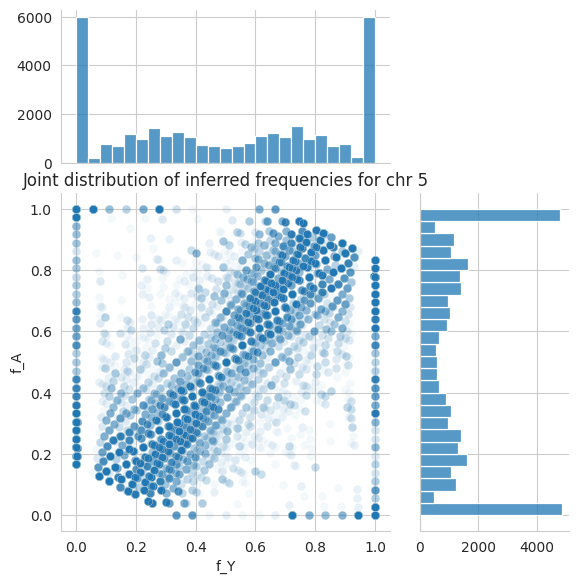

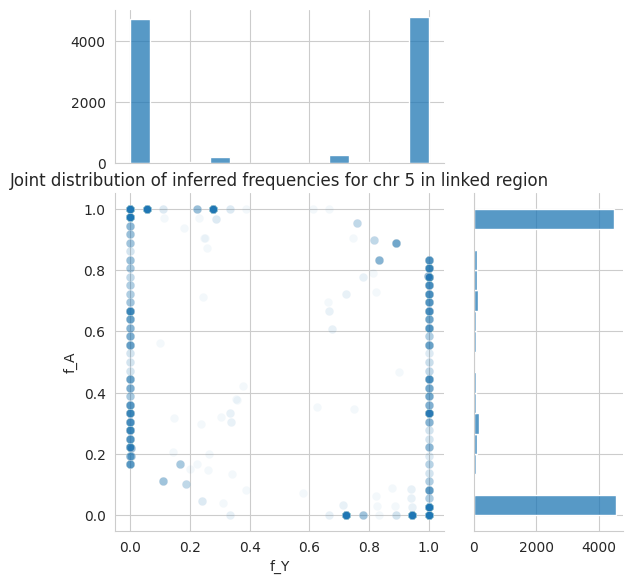

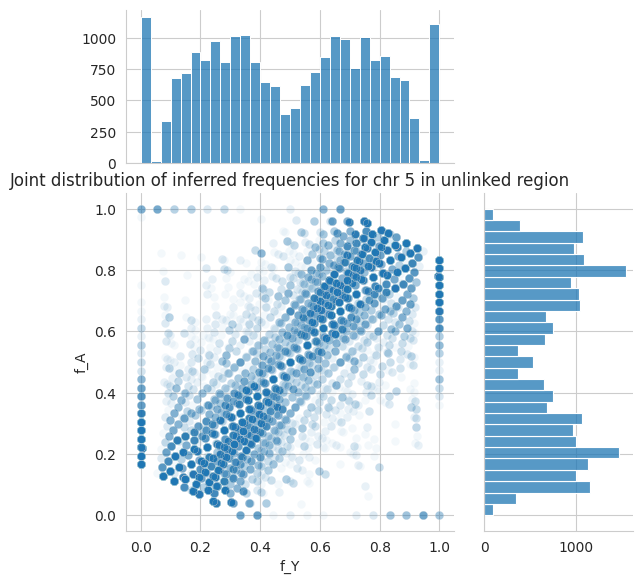

In [ ]:
### plotting

# distribution of frequencies
sns.jointplot(res, x="f_Y", y="f_A", alpha = 0.05, marginal_ticks=True, ratio=2)
plt.title("Joint distribution of inferred frequencies for chr 16")
plt.show()

sns.jointplot(res[res["pos"] < 4.5e7], x="f_Y", y="f_A", alpha = 0.05, marginal_ticks=True, ratio=2)
plt.title("Joint distribution of inferred frequencies for chr 16 in linked region")
plt.show()

sns.jointplot(res[res["pos"] > 5.5e7], x="f_Y", y="f_A", alpha = 0.05, marginal_ticks=True, ratio=2)
plt.title("Joint distribution of inferred frequencies for chr 16 in unlinked region")
plt.show()

### test statistics
#sns.jointplot(res, x="pos", y="test1", alpha=0.02)
#plt.show()

#sns.jointplot(res[res["pos"] > 5.1e7], x="pos", y="test1", alpha=0.02)
#plt.show()

#sns.jointplot(res, x="pos", y="test2", alpha=0.02)
#plt.show()

#sns.jointplot(res[res["pos"] > 5.1e7], x="pos", y="test2", alpha=0.02)
#plt.show()

#sns.jointplot(res, x="pos", y="test3", alpha=0.02)
#plt.show()

#sns.jointplot(res[res["pos"] > 5.1e7], x="pos", y="test3", alpha=0.02)
#plt.show()

### p-values
sns.jointplot(res[res["pos"] > 5.1e7], x="pos", y="logp1")
plt.axhline(np.log10(cutoff_cor), color="y", lw=1.2)
plt.title("p-values for LRT on null model 1 in unlinked region", y=-0.16)
plt.xlabel("position")
plt.ylabel("log10(p-value)")
plt.show()


sns.jointplot(res, x="pos", y="logp1", alpha=0.02)
plt.axhline(np.log10(cutoff_cor), color="y", lw=1.2)
plt.title("p-values for LRT on null model 1 (f_Y = f_A)", y=-0.16)
plt.xlabel("position")
plt.ylabel("log10(p-value)")
plt.show()

sns.jointplot(res, x="pos", y="logp2", alpha=0.02)
plt.axhline(np.log10(cutoff_cor), color="y", lw=1.2)
plt.title("p-values for LRT on null model 2 (f_Y fixed)", y=-0.16)
plt.xlabel("position")
plt.ylabel("log10(p-value)")
plt.show()

sns.jointplot(res, x="pos", y="logp3", alpha=0.02)
plt.axhline(np.log10(cutoff_cor), color="y", lw=1.2)
plt.title("p-values for LRT on null model 3 (f_A fixed)", y=-0.16)
plt.xlabel("position")
plt.ylabel("log10(p-value)")
plt.show()



### sig 2 & 3
sns.jointplot(res, x="f_Y", y="f_A", hue="sig2&3", alpha = 0.2, marginal_ticks=True, ratio=2)
plt.show()

sns.jointplot(res[res["pos"] < 5.1e7], x="f_Y", y="f_A", hue="sig2&3", alpha = 0.2, marginal_ticks=True, ratio=2)
plt.title("Joint distribution of inferred frequencies for chr 16 in linked region")
plt.show()

sns.jointplot(res[(res["pos"] < 5.1e7) & (res['f_Y'] <.99) & (res['f_Y'] >.01) & (res['f_A'] <.99) & (res['f_A'] >.01)], x="f_Y", y="f_A", hue="sig2&3", alpha = 0.2, marginal_ticks=True, ratio=2)
plt.title("Joint distribution of inferred frequencies for chr 16 in linked region")
plt.show()

sns.jointplot(res[res["pos"] < 5.1e7], x="f_Y", y="f_A", hue="sig2&3_cor", alpha = 0.2, marginal_ticks=True, ratio=2)
plt.title("Joint distribution of inferred frequencies for chr 16 in linked region")
plt.show()

sns.jointplot(res[(res["pos"] < 5.1e7) & (res['f_Y'] <.99) & (res['f_Y'] >.01) & (res['f_A'] <.99) & (res['f_A'] >.01)], x="f_Y", y="f_A", hue="sig2&3_cor", alpha = 0.2, marginal_ticks=True, ratio=2)
plt.title("Joint distribution of inferred frequencies for chr 16 in linked region")
plt.show()

sns.histplot(res[res["sig2&3"] & (res["pos"] < 5.1e7)], x="pos", bins=50)
plt.show()

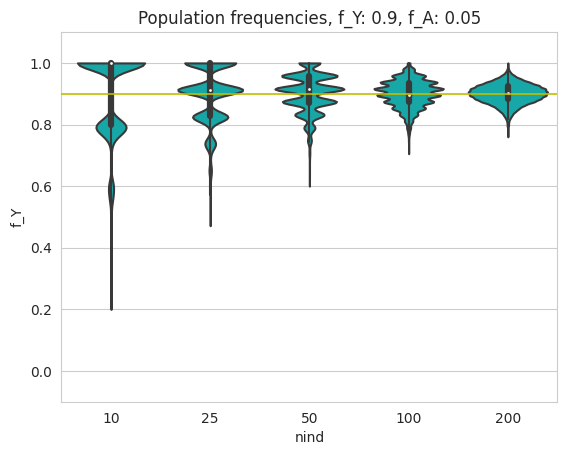

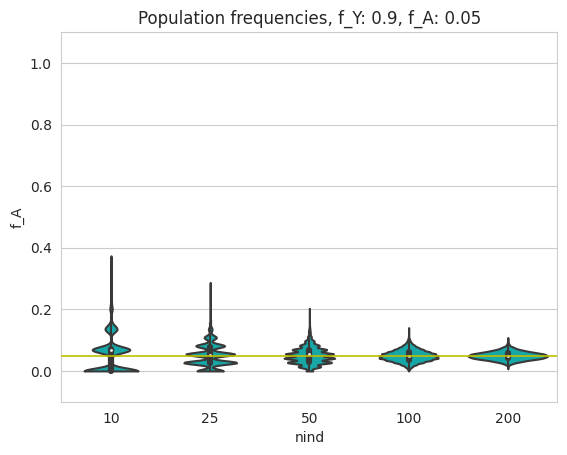

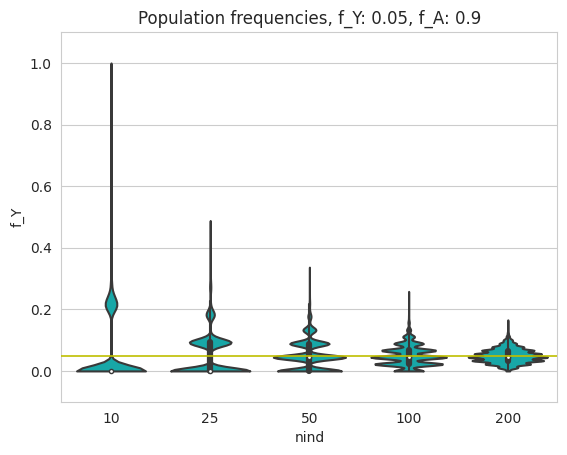

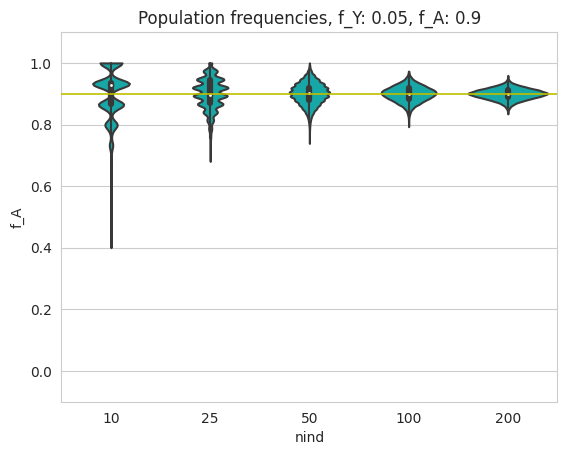

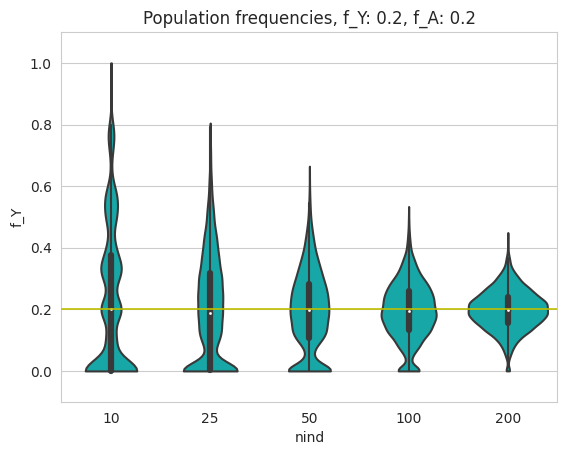

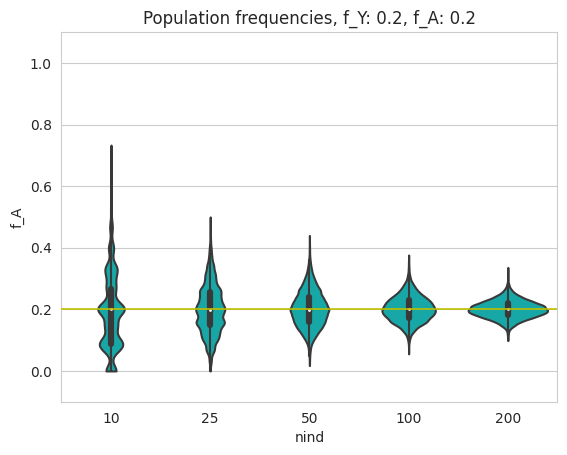

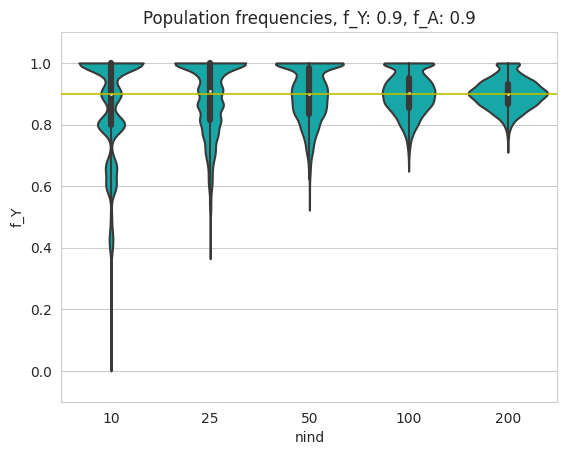

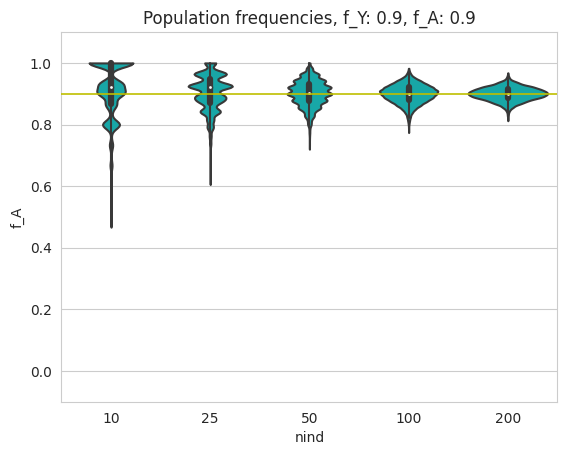

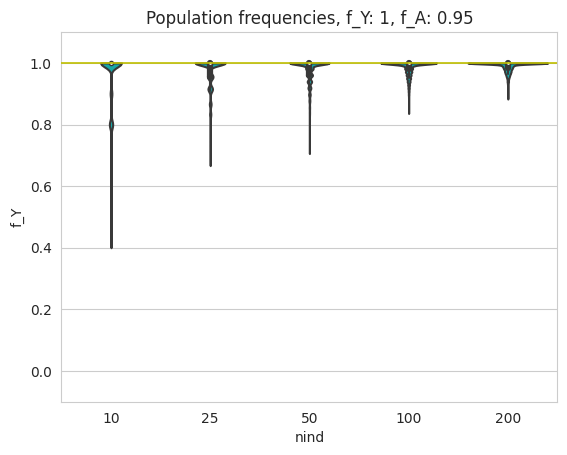

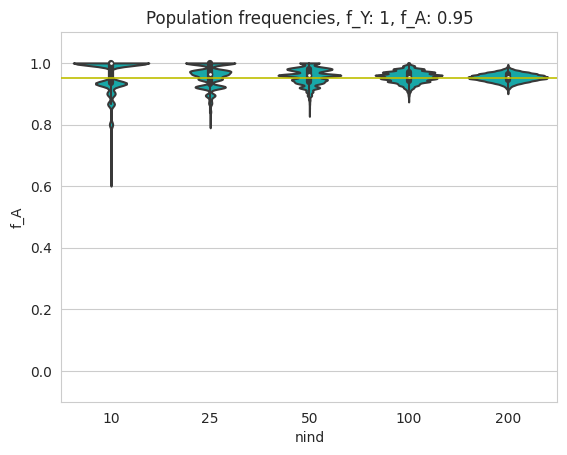

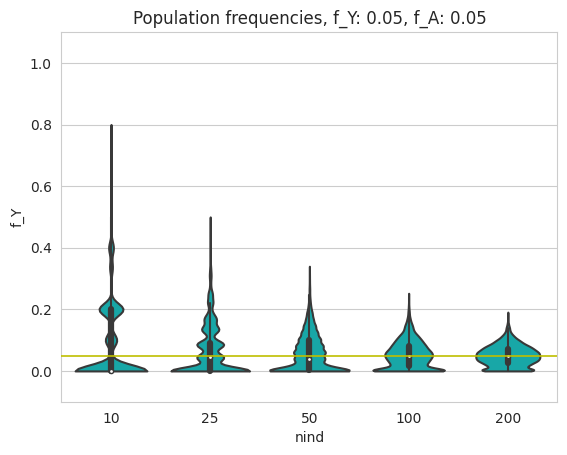

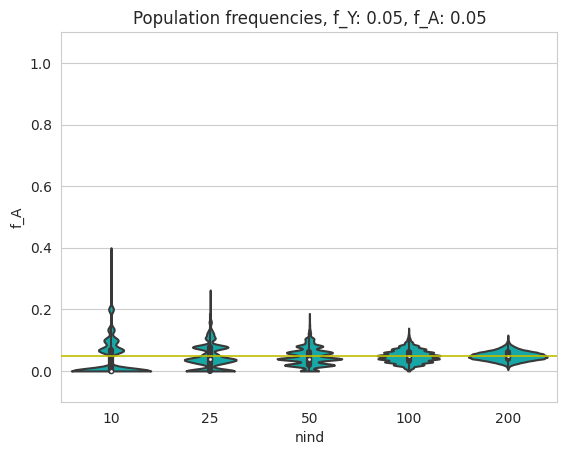

In [ ]:
### sim
for simfrq in [[.6, .4], [.0, .7], [.7, .0], [.5, .5]]: # for main
#for simfrq in [[.9, .05], [.05, .9], [.2, .2], [.9, .9], [1, .95], [.05, .05]]: # for appendix
  simres = pd.DataFrame(columns=["f_Y", "f_A", "nind"])
  for n in [10, 25, 50, 100, 200]:

    simgeno, true_freqs, simmale = sim(nind=n, fixfrq=simfrq)
    simfreqs=[]
    for i in range(len(simgeno)):
      simfreqs.append(converge(simgeno[i], simmale))

    inferred = pd.DataFrame(np.array(simfreqs), columns=["f_Y", "f_A"])
    inferred["nind"] = n
    simres = pd.concat([simres, inferred])


  sns.set_style("whitegrid")

  sns.violinplot(simres, y="f_Y", x="nind", color="c", cut=0)
  plt.title(f"Population frequencies, f_Y: {simfrq[0]}, f_A: {simfrq[1]}")
  plt.axhline(simfrq[0], color="y", lw=1.2, zorder=3)
  plt.ylim((-0.1, 1.1))
  plt.show()

  sns.violinplot(simres, y="f_A", x="nind", color="c", cut=0)
  plt.title(f"Population frequencies, f_Y: {simfrq[0]}, f_A: {simfrq[1]}")
  plt.axhline(simfrq[1], color="y", lw=1.2, zorder=3)
  plt.ylim((-0.1, 1.1))
  plt.show()

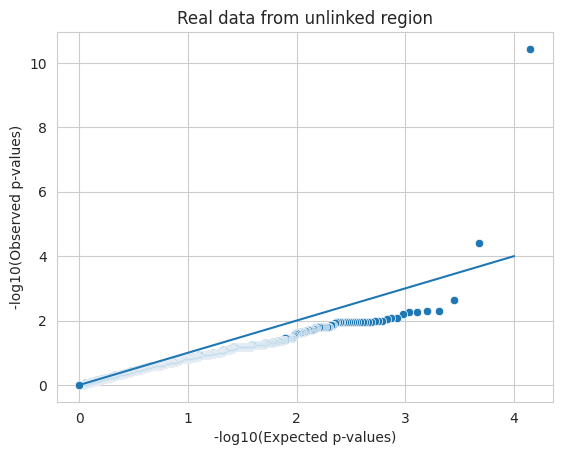

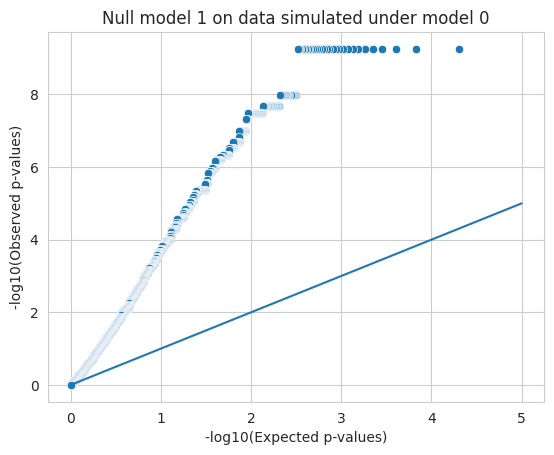

<ipython-input-9-e352c47b3112>:54: RuntimeWarning: divide by zero encountered in log10
  sns.scatterplot(x=-np.log10(qunif), y=-np.log10(np.sort(p)))


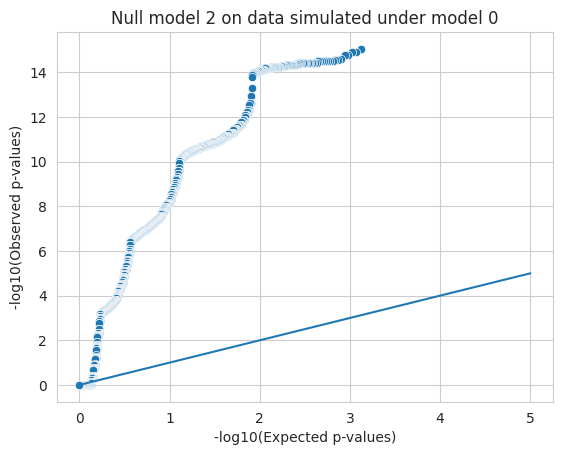

<ipython-input-9-e352c47b3112>:54: RuntimeWarning: divide by zero encountered in log10
  sns.scatterplot(x=-np.log10(qunif), y=-np.log10(np.sort(p)))


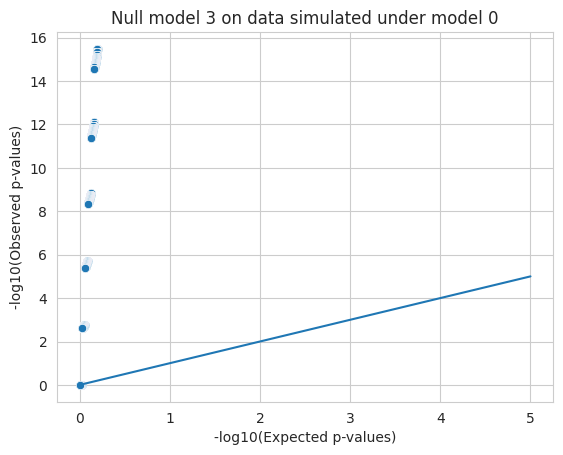

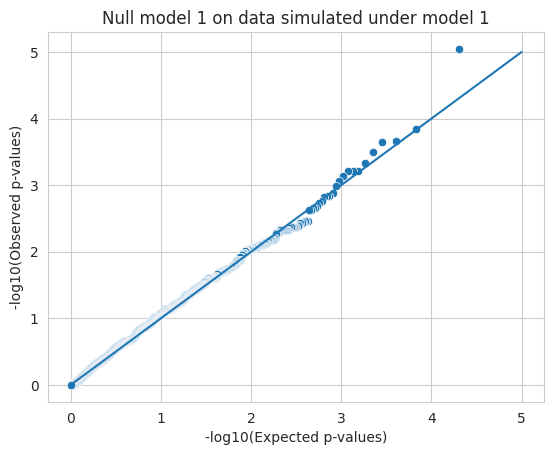

<ipython-input-9-e352c47b3112>:54: RuntimeWarning: divide by zero encountered in log10
  sns.scatterplot(x=-np.log10(qunif), y=-np.log10(np.sort(p)))


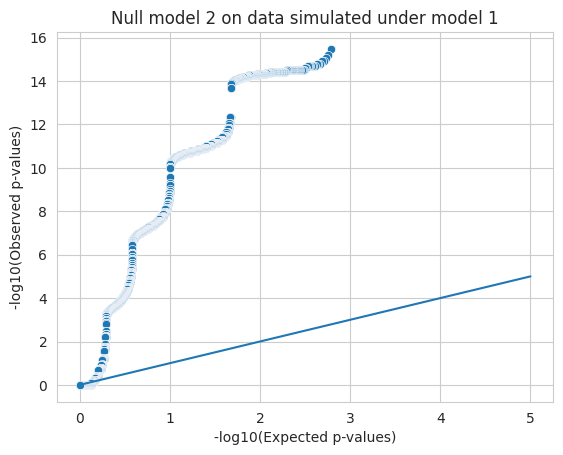

<ipython-input-9-e352c47b3112>:54: RuntimeWarning: divide by zero encountered in log10
  sns.scatterplot(x=-np.log10(qunif), y=-np.log10(np.sort(p)))


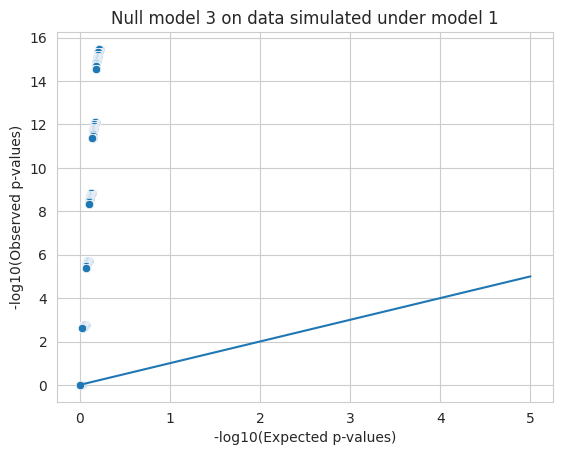

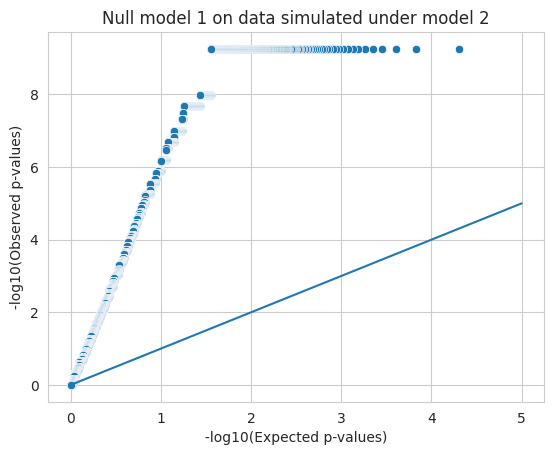

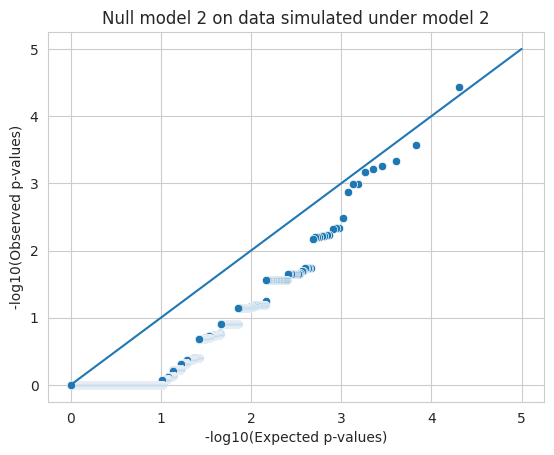

<ipython-input-9-e352c47b3112>:54: RuntimeWarning: divide by zero encountered in log10
  sns.scatterplot(x=-np.log10(qunif), y=-np.log10(np.sort(p)))


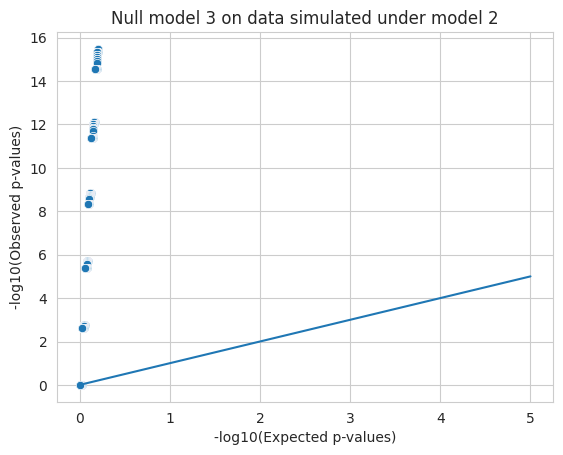

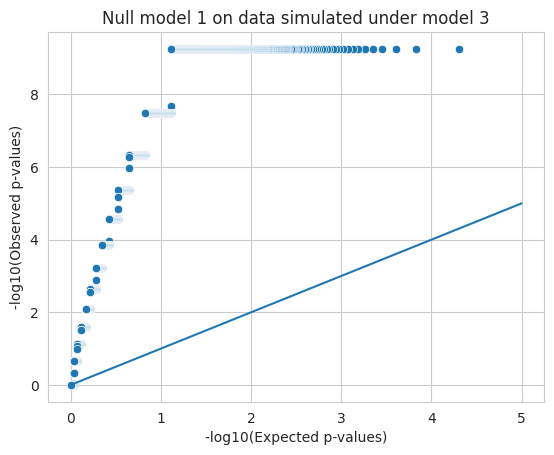

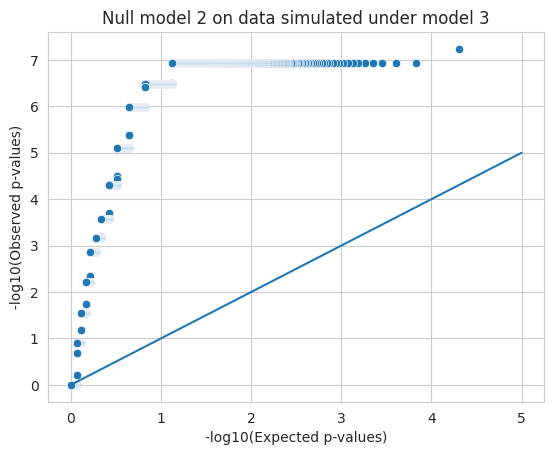

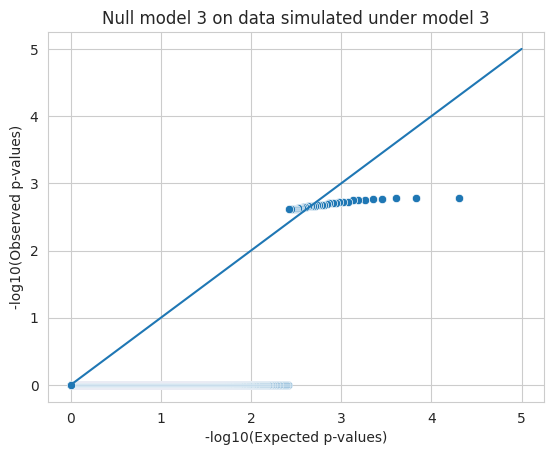

In [ ]:
### QQplot test lrt
### real data

len_linked = len(res[res["pos"] > 5.1e7])
qunif = (np.arange(1, len_linked + 1) - 0.5) / len_linked # expected p-values

#sns.scatterplot(x=np.sort(res[res["pos"] > 5.1e7]["p1"]), y=qunif)
#sns.lineplot(x=[0,1], y=[0,1])
#plt.title("Real data")
#plt.xlabel("Observed p-values")
#plt.ylabel("Expected p-values")
#plt.show()

sns.scatterplot(y=-np.log10(np.sort(res[res["pos"] > 5.1e7]["p1"])), x=-np.log10(qunif))
sns.lineplot(x=[0,4], y=[0,4])
plt.title("Real data from unlinked region")
plt.xlabel("-log10(Expected p-values)")
plt.ylabel("-log10(Observed p-values)")
plt.show()

### null models
qunif = (np.arange(1, 10_001) - .5) / 10_000

for sim_model in [0, 1, 2, 3]:
  simgeno, _, simmale = sim(nind=25, model=sim_model)

  for null_model in [1, 2, 3]:
    p = []
    for i in range(len(simgeno)):
      llik = ll(converge(simgeno[i], simmale), simgeno[i], simmale)
      if null_model == 1:
        frq_null = np.mean(simgeno[i]) / 2
        frq_null = np.array([frq_null, frq_null])
      elif null_model == 2:
        frq_null_0 = converge(simgeno[i], simmale, fixY=1e-4)
        frq_null_1 = converge(simgeno[i], simmale, fixY=1-1e-4)
        if ll(frq_null_0, simgeno[i], simmale) > ll(frq_null_1, simgeno[i], simmale):
          frq_null = frq_null_0
        else:
          frq_null = frq_null_1

      else:
        frq_null_0 = converge(simgeno[i], simmale, fixA=1e-4)
        frq_null_1 = converge(simgeno[i], simmale, fixA=1-1e-4)
        if ll(frq_null_0, simgeno[i], simmale) > ll(frq_null_1, simgeno[i], simmale):
          frq_null = frq_null_0
        else:
          frq_null = frq_null_1

      llik_null = ll(frq_null, simgeno[i], simmale)
      lrt = 2 * ( llik - llik_null)
      p.append(1 - chi2.cdf(lrt, df=1))

    sns.scatterplot(x=-np.log10(qunif), y=-np.log10(np.sort(p)))
    sns.lineplot(x=[0,5], y=[0,5])
    plt.title(f"Null model {null_model} on data simulated under model {sim_model}")
    plt.xlabel("-log10(Expected p-values)")
    plt.ylabel("-log10(Observed p-values)")
    plt.show()

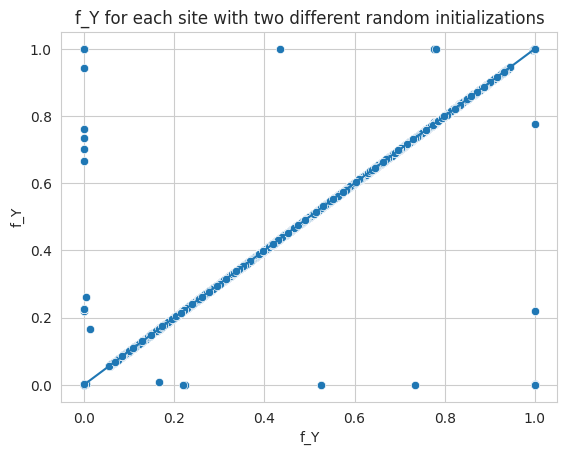

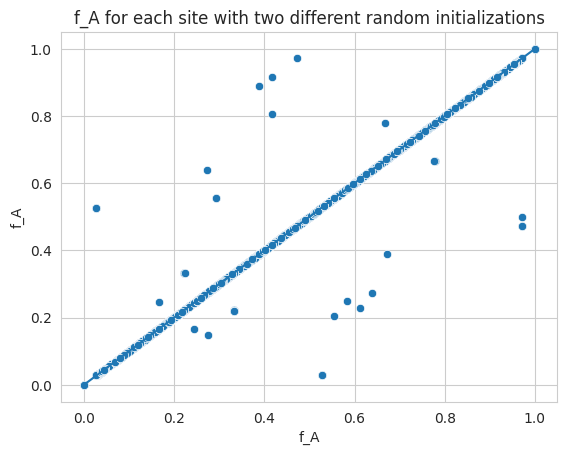

In [ ]:
### test convergence
randinit_frqs1 = []
randinit_frqs2 = []
for i in range(len(geno)):
  randinit_frqs1.append(converge(geno[i], male, randomInit=True))
  randinit_frqs2.append(converge(geno[i], male, randomInit=True))

randinit_frqs1 = np.array(randinit_frqs1)
randinit_frqs2 = np.array(randinit_frqs2)

sns.scatterplot(x=randinit_frqs1[:,0], y=randinit_frqs2[:,0])
sns.lineplot(x=[0,1], y=[0,1])
plt.title("f_Y for each site with two different random initializations")
plt.xlabel("f_Y")
plt.ylabel("f_Y")
plt.show()

sns.scatterplot(x=randinit_frqs1[:,1], y=randinit_frqs2[:,1])
sns.lineplot(x=[0,1], y=[0,1])
plt.title("f_A for each site with two different random initializations")
plt.xlabel("f_A")
plt.ylabel("f_A")
plt.show()

diff = randinit_frqs1 - randinit_frqs2
logdiff = np.log10(diff)[(diff[:, 0] > 1e-4) | (diff[:, 1] > 1e-4)]

np.mean(diff[:20000, 0] > 1e-4)
np.mean(diff[:20000, 1] > 1e-4)

#sns.histplot(logdiff[:20000,0])
#sns.histplot(logdiff[:20000,1])

diff
res["converged"] = (diff[:, 0] < 5e-2) & (diff[:, 1] < 5e-2)
np.mean(~res["converged"])

In [ ]:
### playground block

#np.unique(bed.compute(), return_counts=True)
#np.unique(freq.compute(), return_counts=True)



#EMInferFreqs(np.array([0.5, 0.25]), geno[0], sex, verbose=True)

#converge(geno[4], sex)


#print(np.array([geno[0], sex]).T)
#multiprocessing.cpu_count()

#res[res['f_Y']==0]
#res[res["p1"]>0.5]
#converge(geno[6], male, fixA=True)
#1 - chi2.cdf(40, df=1)
res
np.mean(res["sig2&3"] & (res["pos"] < 5.1e7))
#int(np.rint(1 * 0.5))
#np.array([True] * 5 + [False] * (10 - 5))

sns.histplot(res[~res["converged"]], x="pos", bins=100)
#sns.histplot(res, x="pos", bins=100)
plt.show()


sns.jointplot(res[~res["converged"]], x="f_Y", y="f_A", alpha = 0.05, marginal_ticks=True, ratio=2)
plt.show()

sns.jointplot(res[res["pos"] < 5.1e7], x="f_Y", y="f_A", alpha = 0.05, marginal_ticks=True, ratio=2)
plt.show()


geno[res["sig2&3"]][:, male][:5]
geno[res["sig2&3"]][:, ~male][:5]

res

32863